In [26]:
import pandas as pd
import numpy as np
import datetime as dt
from pandas_datareader import data as pdr
from scipy.stats import norm, t
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd

In [27]:
import yfinance as yf
import numpy as np
import pandas as pd
import datetime as dt

# Function to fetch stock data and compute returns and covariance matrix
def fetch_stock_data(tickers, start_date, end_date):
    stock_data = yf.download(tickers, start=start_date, end=end_date)['Close']
    daily_returns = stock_data.pct_change().dropna()
    mean_returns = daily_returns.mean()
    cov_matrix = daily_returns.cov()
    return daily_returns, mean_returns, cov_matrix

# Function to calculate expected portfolio return and risk
def calculate_portfolio_performance(weights, mean_returns, cov_matrix, time_horizon):
    expected_return = np.dot(weights, mean_returns) * time_horizon
    portfolio_std = np.sqrt(weights.T @ cov_matrix @ weights) * np.sqrt(time_horizon)
    return expected_return, portfolio_std

# Define stock tickers and date range
tickers = ['NPSNY', 'ANGPY', 'GOOG', 'IONQ']
end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=800)

# Fetch data and compute key statistics
daily_returns, mean_returns, cov_matrix = fetch_stock_data(tickers, start_date, end_date)

# Generate random portfolio weights and normalize them
weights = np.random.rand(len(tickers))
weights /= weights.sum()

# Compute portfolio returns
daily_returns['portfolio'] = daily_returns @ weights


[*********************100%***********************]  4 of 4 completed


# Historical VAR

In [28]:
import numpy as np
import pandas as pd

# Function to calculate historical Value at Risk (VaR)
def compute_historical_var(returns, confidence_level=5):
    if isinstance(returns, pd.Series):
        return np.percentile(returns, confidence_level)
    
    if isinstance(returns, pd.DataFrame):
        return returns.aggregate(compute_historical_var, confidence_level=confidence_level)
    
    raise TypeError("Input 'returns' must be a pandas DataFrame or Series.")

# Function to calculate historical Conditional Value at Risk (CVaR)
def compute_historical_cvar(returns, confidence_level=5):
    if isinstance(returns, pd.Series):
        var_threshold = compute_historical_var(returns, confidence_level=confidence_level)
        return returns[returns <= var_threshold].mean()
    
    if isinstance(returns, pd.DataFrame):
        return returns.aggregate(compute_historical_cvar, confidence_level=confidence_level)
    
    raise TypeError("Input 'returns' must be a pandas DataFrame or Series.")

# Define time horizon for risk estimation
time_horizon = 100

# Compute risk measures
historical_var = -compute_historical_var(daily_returns['portfolio'], confidence_level=5) * np.sqrt(time_horizon)
historical_cvar = -compute_historical_cvar(daily_returns['portfolio'], confidence_level=5) * np.sqrt(time_horizon)

# Compute expected portfolio return and standard deviation
portfolio_return, portfolio_std = calculate_portfolio_performance(weights, mean_returns, cov_matrix, time_horizon)

# Define initial investment
initial_investment = 10_000

# Display results
print(f"Expected Portfolio Return:      {round(initial_investment * portfolio_return, 2)}")
print(f"Value at Risk (95% CI):         {round(initial_investment * historical_var, 2)}")
print(f"Conditional VaR (95% CI):       {round(initial_investment * historical_cvar, 2)}")


Expected Portfolio Return:      1305.71
Value at Risk (95% CI):         2423.65
Conditional VaR (95% CI):       3388.52


# Parametric VAR

In [29]:


# Function to compute parametric VaR
def compute_parametric_var(expected_return, portfolio_std, distribution='normal', confidence_level=5, degrees_of_freedom=6):
    if distribution == 'normal':
        var = norm.ppf(1 - confidence_level / 100) * portfolio_std - expected_return
    elif distribution == 't-distribution':
        var = np.sqrt((degrees_of_freedom - 2) / degrees_of_freedom) * t.ppf(1 - confidence_level / 100, degrees_of_freedom) * portfolio_std - expected_return
    else:
        raise ValueError("Expected distribution type 'normal' or 't-distribution'.")
    return var

# Function to compute parametric CVaR
def compute_parametric_cvar(expected_return, portfolio_std, distribution='normal', confidence_level=5, degrees_of_freedom=6):
    if distribution == 'normal':
        cvar = (confidence_level / 100) ** -1 * norm.pdf(norm.ppf(confidence_level / 100)) * portfolio_std - expected_return
    elif distribution == 't-distribution':
        xanu = t.ppf(confidence_level / 100, degrees_of_freedom)
        cvar = -1 / (confidence_level / 100) * (1 - degrees_of_freedom) ** -1 * (degrees_of_freedom - 2 + xanu ** 2) * t.pdf(xanu, degrees_of_freedom) * portfolio_std - expected_return
    else:
        raise ValueError("Expected distribution type 'normal' or 't-distribution'.")
    return cvar

# Compute VaR and CVaR using normal and t-distributions
normal_var = compute_parametric_var(portfolio_return, portfolio_std)
normal_cvar = compute_parametric_cvar(portfolio_return, portfolio_std)

t_var = compute_parametric_var(portfolio_return, portfolio_std, distribution='t-distribution')
t_cvar = compute_parametric_cvar(portfolio_return, portfolio_std, distribution='t-distribution')

# Print results
print(f"Normal VaR (95% CI):      {round(initial_investment * normal_var, 2)}")
print(f"Normal CVaR (95% CI):     {round(initial_investment * normal_cvar, 2)}")
print(f"t-dist VaR (95% CI):      {round(initial_investment * t_var, 2)}")
print(f"t-dist CVaR (95% CI):     {round(initial_investment * t_cvar, 2)}")


Normal VaR 95th CI       :       2702.62
Normal CVaR 95th CI      :       3929.77
t-dist VaR 95th CI       :       2531.55
t-dist CVaR 95th CI      :       4204.22


# Monte Carlo VAR

In [38]:
import numpy as np

# Monte Carlo Simulation for Portfolio Performance
num_simulations = 400  # Number of Monte Carlo simulations
time_horizon = 100  # Timeframe in days

# Create mean return matrix
mean_returns_matrix = np.tile(mean_returns.values, (time_horizon, 1))  # Shape (100, 4)

# Initialize portfolio simulations matrix
portfolio_simulations = np.zeros((time_horizon, num_simulations))

# Set initial portfolio value
initial_portfolio_value = 10_000

# Monte Carlo simulations
for sim in range(num_simulations):
    # Generate correlated random returns
    random_shocks = np.random.normal(size=(time_horizon, len(weights)))  # Shape (100, 4)
    cholesky_decomp = np.linalg.cholesky(cov_matrix)  # Shape (4,4)

    # Generate simulated daily returns
    simulated_daily_returns = mean_returns_matrix + random_shocks @ cholesky_decomp.T  # Shape (100, 4)

    # Compute cumulative portfolio returns
    portfolio_simulations[:, sim] = np.cumprod(np.dot(simulated_daily_returns, weights) + 1) * initial_portfolio_value  # Shape (100,)



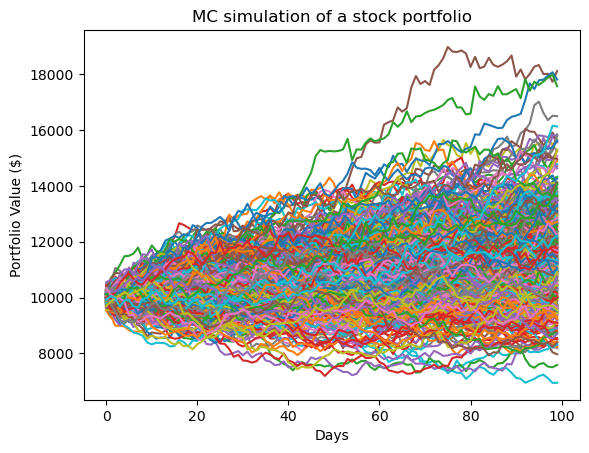

In [39]:
plt.plot(portfolio_simulations)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title('MC simulation of a stock portfolio')
plt.show()

In [40]:
# Function to compute Monte Carlo Value at Risk (VaR)
def compute_mc_var(returns: pd.Series, confidence_level=5) -> float:
    if not isinstance(returns, pd.Series):
        raise TypeError("Expected 'returns' to be a pandas Series.")
    
    return np.percentile(returns, confidence_level)

# Function to compute Monte Carlo Conditional Value at Risk (CVaR)
def compute_mc_cvar(returns: pd.Series, confidence_level=5) -> float:
    if not isinstance(returns, pd.Series):
        raise TypeError("Expected 'returns' to be a pandas Series.")
    
    var_threshold = compute_mc_var(returns, confidence_level)
    return returns[returns <= var_threshold].mean()


In [41]:
# Extract final portfolio values from Monte Carlo simulations
portfolio_final_values = pd.Series(portfolio_simulations[-1, :])

# Compute Monte Carlo-based VaR and CVaR
var_mc = initial_portfolio_value - compute_mc_var(portfolio_final_values, confidence_level=5)
cvar_mc = initial_portfolio_value - compute_mc_cvar(portfolio_final_values, confidence_level=5)

# Display results
print(f"Monte Carlo VaR (95% CI):  ${round(var_mc, 2)}")
print(f"Monte Carlo CVaR (95% CI): ${round(cvar_mc, 2)}")


Monte Carlo VaR (95% CI):  $1109.47
Monte Carlo CVaR (95% CI): $1674.57
